In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)

In [2]:
def sigmoid(z):
    x=tf.placeholder(tf.float32,name="x")
    
    sigmoid=tf.sigmoid(x)
    
    with tf.Session() as sess:
        result=sess.run(sigmoid,feed_dict={x:z})
    return result

In [3]:
def one_hot_matrix(labels,C):
    C=tf.constant(C,name='C')
    one_hot_matrix=tf.one_hot(indices=labels,depth=C,axis=0)
    sess=tf.Session()
    one_hot=sess.run(one_hot_matrix)
    sess.close()
    return one_hot

In [4]:
x_train_orig,y_train_orig,x_test_orig,y_test_orig,classes=load_dataset()

y = 5


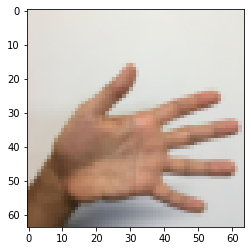

In [5]:
index=0
plt.imshow(x_train_orig[index])
print("y = "+str(np.squeeze(y_train_orig[:,index])))

In [6]:
x_train_flatten=x_train_orig.reshape(x_train_orig.shape[0],-1).T
x_test_flatten=x_test_orig.reshape(x_test_orig.shape[0],-1).T

x_train=x_train_flatten/255
x_test=x_test_flatten/255

y_train=convert_to_one_hot(y_train_orig,6)
y_test=convert_to_one_hot(y_test_orig,6)

print("number of training examples = "+str(x_train.shape[1]))
print("number of test examples = "+str(x_test.shape[1]))
print("X_train shape: "+str(x_train.shape))
print("Y_train shape: "+str(y_train.shape))
print("X_test shape: "+str(x_test.shape))
print("Y_test shape"+str(y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape(6, 120)


In [7]:
def create_placeholder(n_x,n_y):
    
    X=tf.placeholder(tf.float32,[n_x,None],name="X")
    Y=tf.placeholder(tf.float32,[n_y,None],name="Y")
    
    return X,Y

In [8]:
X,Y=create_placeholder(12288,6)
print("X = "+str(X))
print("Y = "+str(Y))

X = Tensor("X:0", shape=(12288, ?), dtype=float32)
Y = Tensor("Y:0", shape=(6, ?), dtype=float32)


In [9]:
def initialize_parameters():

    tf.set_random_seed(1)                  

    W1 = tf.get_variable("W1", [25, 12288], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [25, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [12, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [6, 12], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [6, 1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [10]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
W1 = <tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>


In [11]:
def forward_propagation(X, parameters):
 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']

    Z1 = tf.add(tf.matmul(W1, X), b1)                     
    A1 = tf.nn.relu(Z1)                                    
    Z2 = tf.add(tf.matmul(W2, A1), b2)                    
    A2 = tf.nn.relu(Z2)                                    
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     
    
    return Z3

In [12]:
tf.reset_default_graph()

with tf.Session() as sess:
    X,Y=create_placeholder(12288,6)
    parameters=initialize_parameters()
    Z3=forward_propagation(X,parameters)
    print("Z3 = "+str(Z3))

Z3 = Tensor("Add_2:0", shape=(6, ?), dtype=float32)


In [13]:
def compute_cost(Z3,Y):
    logits=tf.transpose(Z3)
    labels=tf.transpose(Y)
    
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    
    return cost

In [14]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholder(12288, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

cost = Tensor("Mean:0", shape=(), dtype=float32)


In [15]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):

    ops.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                          
    (n_x, m) = X_train.shape                          
    n_y = Y_train.shape[0]                           
    costs = []                                        

    X, Y = create_placeholder(n_x, n_y)
    
    parameters = initialize_parameters()
    
    Z3 = forward_propagation(X, parameters)
    
    cost = compute_cost(Z3, Y)

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    init = tf.global_variables_initializer()

    with tf.Session() as sess:

        sess.run(init)

        for epoch in range(num_epochs):

            epoch_cost = 0.                     
            num_minibatches = int(m / minibatch_size) 
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch

                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)

        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 1.855702
Cost after epoch 100: 1.017255
Cost after epoch 200: 0.733184
Cost after epoch 300: 0.573071
Cost after epoch 400: 0.468573
Cost after epoch 500: 0.381228
Cost after epoch 600: 0.313815
Cost after epoch 700: 0.253708
Cost after epoch 800: 0.203900
Cost after epoch 900: 0.166454
Cost after epoch 1000: 0.146636
Cost after epoch 1100: 0.107279
Cost after epoch 1200: 0.086698
Cost after epoch 1300: 0.059342
Cost after epoch 1400: 0.052289


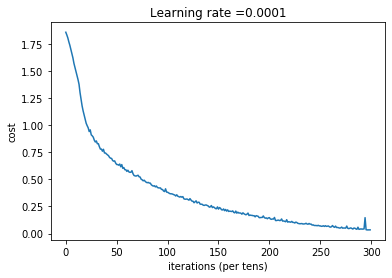

Parameters have been trained!
Train Accuracy: 0.9990741
Test Accuracy: 0.725


In [16]:
parameters=model(x_train,y_train,x_test,y_test)

C:\Users\Hrishikesh D S\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Hrishikesh D S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  if sys.path[0] == '':


Your algorithm predicts: y = 0


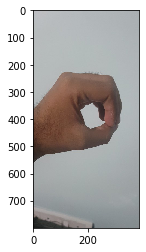

In [32]:
import scipy
from PIL import Image
from scipy import ndimage

## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "h0.jpg"
## END CODE HERE ##

# We preprocess your image to fit your algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64, 64)).reshape((1, 64 * 64 * 3)).T
my_image_prediction = predict(my_image, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))

### 